## Problem Statement 

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling 

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [160]:
# Import required packages
import nltk
import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load(disable=['parser','ner'])
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from collections import Counter

from sklearn.feature_extraction.text import TfidfTransformer

%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from textblob import TextBlob

import warnings
warnings.filterwarnings('ignore')
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, f1_score, classification_report

In [161]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [162]:
from google.colab import drive
drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [163]:
# Opening JSON file 
f = open('/content/gdrive/MyDrive/Colab Notebooks/complaints-2021-05-14_08_16.json')# Write the path to your data file and load it 
  
# returns JSON object as  
# a dictionary 
data = json.load(f)
df=pd.json_normalize(data)

## Data preparation

In [164]:
# Inspect the dataframe to understand the given data.

df.head()

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [165]:
#print the column names
df.columns

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')

In [166]:
#Assign new column names
df.rename(columns={'_source.complaint_what_happened':'complaints', '_source.product':'tag'}, inplace=True)

In [167]:
#print the column names
df.columns

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', 'tag',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely', 'complaints',
       '_source.sub_issue', '_source.consumer_consent_provided'],
      dtype='object')

In [168]:
# Inspect number of rows and number of columns
df.shape

(78313, 22)

In [169]:
# Inspect the number of missing values percentage
round(df.isna().sum()*100/78313,2)

_index                                0.00
_type                                 0.00
_id                                   0.00
_score                                0.00
_source.tags                         86.08
_source.zip_code                      8.63
_source.complaint_id                  0.00
_source.issue                         0.00
_source.date_received                 0.00
_source.state                         2.54
_source.consumer_disputed             0.00
tag                                   0.00
_source.company_response              0.00
_source.company                       0.00
_source.submitted_via                 0.00
_source.date_sent_to_company          0.00
_source.company_public_response      99.99
_source.sub_product                  13.50
_source.timely                        0.00
complaints                            0.00
_source.sub_issue                    59.12
_source.consumer_consent_provided     1.29
dtype: float64

In [170]:
#Assign nan in place of blanks in the complaints column
# There are many blank rows in 'complaints', hence convert them into NaN values
df['complaints'].replace("", np.nan, inplace=True)

In [171]:
# Inspect the number of missing values percentage now
round(df.isna().sum()*100/78313,2)

_index                                0.00
_type                                 0.00
_id                                   0.00
_score                                0.00
_source.tags                         86.08
_source.zip_code                      8.63
_source.complaint_id                  0.00
_source.issue                         0.00
_source.date_received                 0.00
_source.state                         2.54
_source.consumer_disputed             0.00
tag                                   0.00
_source.company_response              0.00
_source.company                       0.00
_source.submitted_via                 0.00
_source.date_sent_to_company          0.00
_source.company_public_response      99.99
_source.sub_product                  13.50
_source.timely                        0.00
complaints                           73.09
_source.sub_issue                    59.12
_source.consumer_consent_provided     1.29
dtype: float64

In [172]:
#Remove all rows where complaints column is nan
df.dropna(subset=['complaints'], inplace=True)

#New shape of df
df.shape

(21072, 22)

In [173]:
# Inspect the number of missing values percentage now
round(df.isna().sum()*100/78313,2)

_index                                0.00
_type                                 0.00
_id                                   0.00
_score                                0.00
_source.tags                         22.03
_source.zip_code                      5.93
_source.complaint_id                  0.00
_source.issue                         0.00
_source.date_received                 0.00
_source.state                         0.18
_source.consumer_disputed             0.00
tag                                   0.00
_source.company_response              0.00
_source.company                       0.00
_source.submitted_via                 0.00
_source.date_sent_to_company          0.00
_source.company_public_response      26.90
_source.sub_product                   2.69
_source.timely                        0.00
complaints                            0.00
_source.sub_issue                    10.44
_source.consumer_consent_provided     0.00
dtype: float64

## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [174]:
# Write your function here to clean the text and remove all the unnecessary elements.
def clean_complaint(text):
    # Make the text lowercase
    text=text.lower()
    
    # Remove text in square brackets
    text=re.sub(r'\[.*?\]','',text)
    
    # Remove punctuation marks
    text=re.sub(r'[%s]%re.escape(string.punctuation)','',text)
    
    # Remove words containing numbers
    text = re.sub(r'\w*\d\w*', '', text)
    
    return text

In [175]:
df['complaints']= df['complaints'].apply(lambda x: clean_complaint(x))

In [176]:
#Write your function to Lemmatize the texts
def text_lemmatize(text):     
        
    # Initialize empty list to store lemmas
    lemmas = []
    
    # Extract lemmas of given text and add to the list 
    document = nlp(text)
    for word in document:
        lemmas.append(word.lemma_)
        
    # return string converted form of the list of lemmas
    return " ".join(lemmas)

In [177]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints 
df_clean = pd.DataFrame({'complaints':df['complaints'], 'lemmatized':df['complaints'].apply(text_lemmatize)})

In [178]:
df_clean.head()

,complaints,lemmatized
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...
2,i upgraded my xxxx xxxx card in xx/xx/ and was...,I upgrade my xxxx xxxx card in xx / xx/ and be...
10,"chase card was reported on xx/xx/. however, fr...","chase card be report on xx / xx/. however , fr..."
11,"on xx/xx/, while trying to book a xxxx xxxx ...","on xx / xx/ , while try to book a xxxx xxxx ..."
14,my grand son give me check for {$.} i deposit ...,my grand son give I check for { $ . } I deposi...


In [179]:
#Write your function to extract the POS tags 

def extract_pos(text):
    sentence = []
    blob = TextBlob(text)
    sentence = [word for (word,tag) in blob.tags if tag=='NN']
    return " ".join(sentence)
    

df_clean["complaint_POS_removed"] =  df_clean.apply(lambda x: extract_pos(x['lemmatized']), axis=1)

In [180]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean.head()

,complaints,lemmatized,complaint_POS_removed
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember ask debt ver...
2,i upgraded my xxxx xxxx card in xx/xx/ and was...,I upgrade my xxxx xxxx card in xx / xx/ and be...,card agent upgrade date agent information orde...
10,"chase card was reported on xx/xx/. however, fr...","chase card be report on xx / xx/. however , fr...",card application identity consent service cred...
11,"on xx/xx/, while trying to book a xxxx xxxx ...","on xx / xx/ , while try to book a xxxx xxxx ...",try book xxxx ticket offer ticket card informa...
14,my grand son give me check for {$.} i deposit ...,my grand son give I check for { $ . } I deposi...,son chase account fund bank account pay money ...


## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




Text(0, 0.5, 'Number of Complaints')

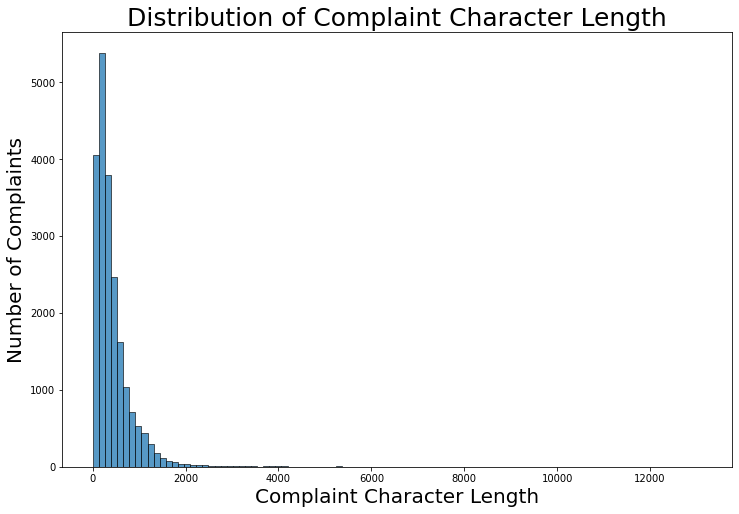

In [181]:
# Write your code here to visualise the data according to the 'Complaint' character length
char_len=[len(x) for x in df_clean['complaint_POS_removed']]

plt.figure(figsize=[12,8])
sns.histplot(data = char_len,bins=100)
plt.title('Distribution of Complaint Character Length', fontsize=25)
plt.xlabel('Complaint Character Length',size=20)
plt.ylabel('Number of Complaints',size=20)

#### Find the top 40 words by frequency among all the articles after processing the text.

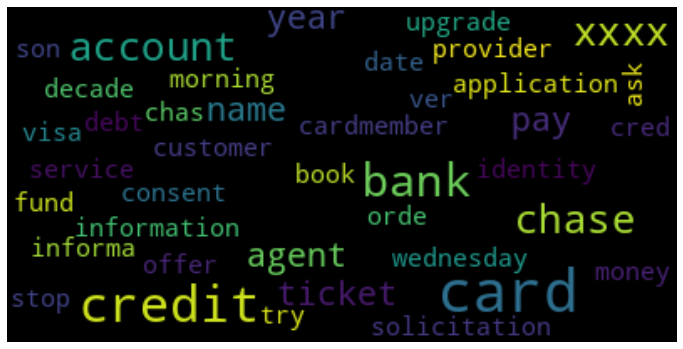

In [182]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
wordcloud = WordCloud(max_words=40, random_state=5, max_font_size=35,stopwords=set(STOPWORDS))
wordcloud.generate(str(df_clean['complaint_POS_removed']))
plt.figure(figsize=(12,12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [183]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [184]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean). 
def get_top_unigram(text, n=30):

    vector = CountVectorizer(stop_words='english').fit(text)
    bag_of_words = vector.transform(text)
    sum_of_words = bag_of_words.sum(axis=0) 
    word_freq = [(word, sum_of_words[0, idx]) for word, idx in vector.vocabulary_.items()]
    word_freq =sorted(word_freq, key = lambda x: x[1], reverse=True)
    return word_freq[:n]

In [185]:
#Print the top 10 words in the unigram frequency
top_common_words = get_top_unigram(df_clean['complaint_POS_removed'].values.astype('U'))
df_unigram = pd.DataFrame(top_common_words, columns = ['unigram' , 'count'])
df_unigram.head(10)

,unigram,count
0,chase,49101
1,account,47895
2,xxxx,43169
3,credit,34283
4,card,29632
5,bank,28508
6,payment,21336
7,time,16289
8,charge,15143
9,day,13065


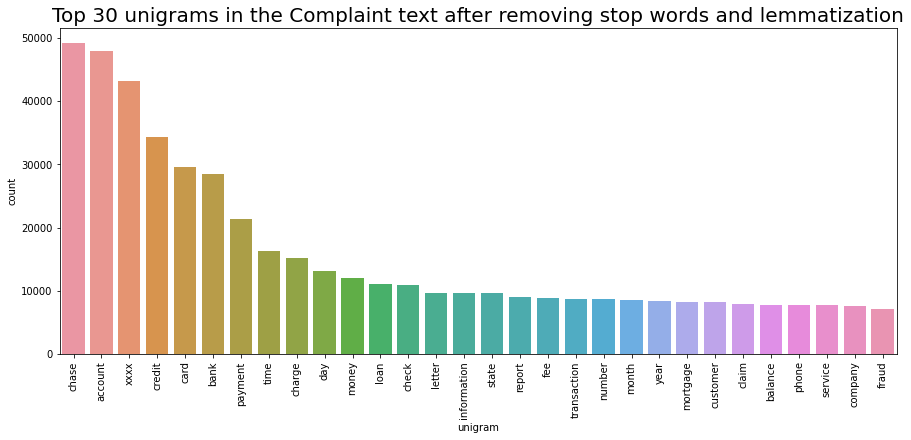

In [186]:
plt.figure(figsize=(15,6))
sns.barplot(x='unigram', y='count', data=df_unigram)
plt.xticks(rotation=90)
plt.title("Top 30 unigrams in the Complaint text after removing stop words and lemmatization", fontsize=20)
plt.show()

In [187]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean). 
def get_top_bigram(text, n=30):

    vector = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(text)
    bag_of_words = vector.transform(text)
    sum_of_words = bag_of_words.sum(axis=0) 
    word_freq = [(word, sum_of_words[0, idx]) for word, idx in vector.vocabulary_.items()]
    word_freq =sorted(word_freq, key = lambda x: x[1], reverse=True)
    return word_freq[:n]

In [188]:
#Print the top 10 words in the bigram frequency
top_common_words = get_top_bigram(df_clean['complaint_POS_removed'].values.astype('U'))
df_bigram = pd.DataFrame(top_common_words, columns = ['bigram' , 'count'])
df_bigram.head(10)

,bigram,count
0,credit card,12879
1,xxxx xxxx,6199
2,credit report,4002
3,customer service,3080
4,chase credit,3058
5,chase bank,2898
6,bank account,2806
7,chase account,2770
8,account chase,2750
9,account account,2335


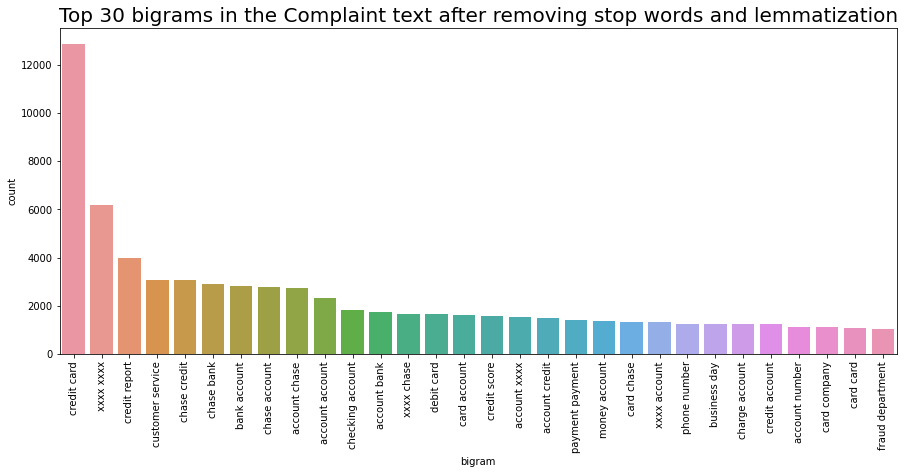

In [189]:
# Plot the top 30 unigrams
plt.figure(figsize=(15,6))
sns.barplot(x='bigram', y='count', data=df_bigram)
plt.xticks(rotation=90)
plt.title("Top 30 bigrams in the Complaint text after removing stop words and lemmatization", fontsize=20)
plt.show()

In [190]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean). 
def get_top_trigram(text, n=30):

    vector = CountVectorizer(ngram_range=(3, 3), stop_words='english').fit(text)
    bag_of_words = vector.transform(text)
    sum_of_words = bag_of_words.sum(axis=0) 
    word_freq = [(word, sum_of_words[0, idx]) for word, idx in vector.vocabulary_.items()]
    word_freq =sorted(word_freq, key = lambda x: x[1], reverse=True)
    return word_freq[:n]

In [191]:
#Print the top 10 words in the trigram frequency
top_common_words = get_top_trigram(df_clean['complaint_POS_removed'].values.astype('U'))
df_trigram = pd.DataFrame(top_common_words, columns = ['trigram' , 'count'])
df_trigram.head(10)

,trigram,count
0,chase credit card,2135
1,xxxx xxxx xxxx,1060
2,credit card account,1057
3,credit card company,994
4,credit card chase,673
5,credit card credit,508
6,inquiry credit report,482
7,charge credit card,431
8,account credit card,418
9,card credit card,382


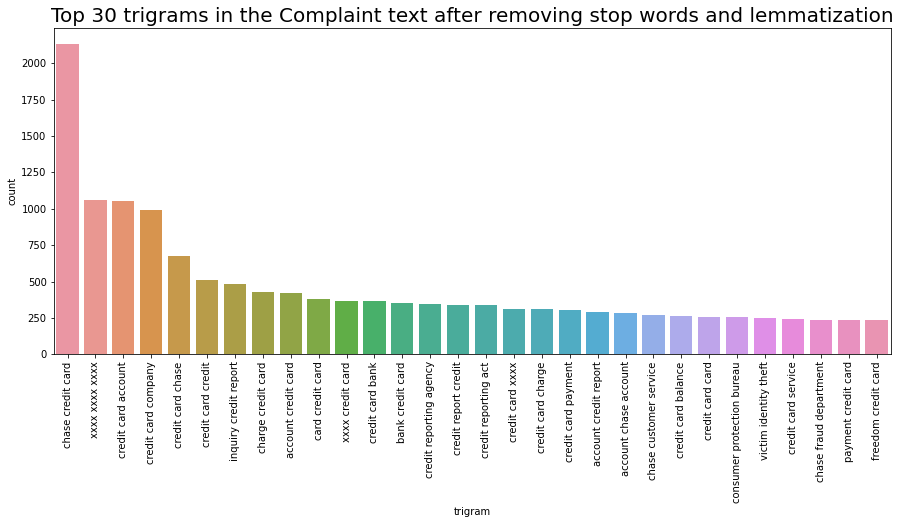

In [192]:
# Plot the top 30 unigrams
plt.figure(figsize=(15,6))
sns.barplot(x='trigram', y='count', data=df_trigram)
plt.xticks(rotation=90)
plt.title("Top 30 trigrams in the Complaint text after removing stop words and lemmatization", fontsize=20)
plt.show()

## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [193]:
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

In [195]:
#All masked texts has been removed
df_clean.head()

,complaints,lemmatized,complaint_POS_removed,Complaint_clean
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember ask debt ver...,morning name stop bank cardmember ask debt ver...
2,i upgraded my xxxx xxxx card in xx/xx/ and was...,I upgrade my xxxx xxxx card in xx / xx/ and be...,card agent upgrade date agent information orde...,card agent upgrade date agent information orde...
10,"chase card was reported on xx/xx/. however, fr...","chase card be report on xx / xx/. however , fr...",card application identity consent service cred...,card application identity consent service cred...
11,"on xx/xx/, while trying to book a xxxx xxxx ...","on xx / xx/ , while try to book a xxxx xxxx ...",try book xxxx ticket offer ticket card informa...,try book ticket offer ticket card information...
14,my grand son give me check for {$.} i deposit ...,my grand son give I check for { $ . } I deposi...,son chase account fund bank account pay money ...,son chase account fund bank account pay money ...


## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [196]:
#Write your code here to initialise the TfidfVectorizer 
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

tfidf = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')

#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [197]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
dtm=tfidf.fit_transform(df_clean['complaint_POS_removed'])

## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

In [198]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [199]:
#Load your nmf_model with the n_components i.e 5
num_topics = 5 #write the value you want to test out

#keep the random_state =40
nmf_model = NMF(random_state=40, n_components=num_topics) #write your code here

In [200]:
nmf_model.fit(dtm)
len(tfidf.get_feature_names_out())

7101

In [201]:
#Print the Top 15 words for each of the topics

for index, topic in enumerate(nmf_model.components_):
    print(f'TOP 15 WORDS FOR TOPIC #{index}')
    print([tfidf.get_feature_names_out()[i] for i in topic.argsort()[-15:]])
    print('\n')

TOP 15 WORDS FOR TOPIC #0
['transfer', 'transaction', 'business', 'number', 'checking', 'day', 'branch', 'xxxx', 'deposit', 'chase', 'fund', 'money', 'check', 'bank', 'account']


TOP 15 WORDS FOR TOPIC #1
['year', 'letter', 'balance', 'application', 'debt', 'information', 'limit', 'company', 'score', 'account', 'chase', 'inquiry', 'report', 'card', 'credit']


TOP 15 WORDS FOR TOPIC #2
['foreclosure', 'house', 'bank', 'time', 'document', 'rate', 'letter', 'year', 'property', 'modification', 'chase', 'home', 'xxxx', 'mortgage', 'loan']


TOP 15 WORDS FOR TOPIC #3
['statement', 'refund', 'time', 'service', 'purchase', 'claim', 'fraud', 'merchant', 'fee', 'dispute', 'transaction', 'chase', 'xxxx', 'card', 'charge']


TOP 15 WORDS FOR TOPIC #4
['mortgage', 'year', 'chase', 'credit', 'account', 'date', 'pay', 'time', 'day', 'auto', 'statement', 'fee', 'month', 'balance', 'payment']




In [202]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4

topic_results = nmf_model.transform(dtm)
topic_results.argmax(axis=1)

array([0, 3, 1, ..., 3, 4, 4])

In [203]:
# verify len is equal to number of rows
len(topic_results)

21072

In [204]:
#Assign the best topic to each of the cmplaints in Topic Column

df_clean['Topic'] = topic_results.argmax(axis=1)

In [205]:
df_clean.head()


,complaints,lemmatized,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember ask debt ver...,morning name stop bank cardmember ask debt ver...,0
2,i upgraded my xxxx xxxx card in xx/xx/ and was...,I upgrade my xxxx xxxx card in xx / xx/ and be...,card agent upgrade date agent information orde...,card agent upgrade date agent information orde...,3
10,"chase card was reported on xx/xx/. however, fr...","chase card be report on xx / xx/. however , fr...",card application identity consent service cred...,card application identity consent service cred...,1
11,"on xx/xx/, while trying to book a xxxx xxxx ...","on xx / xx/ , while try to book a xxxx xxxx ...",try book xxxx ticket offer ticket card informa...,try book ticket offer ticket card information...,1
14,my grand son give me check for {$.} i deposit ...,my grand son give I check for { $ . } I deposi...,son chase account fund bank account pay money ...,son chase account fund bank account pay money ...,0


In [206]:
#Print the first 5 Complaint for each of the Topics
df_clean_5=df_clean.groupby('Topic').head(5)
df_clean_5.sort_values('Topic')

,complaints,lemmatized,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember ask debt ver...,morning name stop bank cardmember ask debt ver...,0
24,mishandling of this account by chase auto and ...,mishandle of this account by chase auto and xx...,mishandle account auto xxxx,mishandle account auto,0
17,with out notice j.p. morgan chase restricted m...,with out notice j.p . morgan chase restrict my...,j.p restrict account debit card tuesday branch...,j.p restrict account debit card tuesday branch...,0
14,my grand son give me check for {$.} i deposit ...,my grand son give I check for { $ . } I deposi...,son chase account fund bank account pay money ...,son chase account fund bank account pay money ...,0
27,i opened an account with chase bank on xxxx an...,I open an account with chase bank on xxxx and ...,account bank code bonus term everything accoun...,account bank code bonus term everything accoun...,0
15,can you please remove inquiry,can you please remove inquiry,inquiry,inquiry,1
10,"chase card was reported on xx/xx/. however, fr...","chase card be report on xx / xx/. however , fr...",card application identity consent service cred...,card application identity consent service cred...,1
23,i have a chase credit card which is incorrectl...,I have a chase credit card which be incorrectl...,chase credit card datum credit report company ...,chase credit card datum credit report company ...,1
26,i have reached out to xxxx several times in at...,I have reach out to xxxx several time in attem...,time attempt inquiry creditor place inquiry re...,time attempt inquiry creditor place inquiry re...,1
11,"on xx/xx/, while trying to book a xxxx xxxx ...","on xx / xx/ , while try to book a xxxx xxxx ...",try book xxxx ticket offer ticket card informa...,try book ticket offer ticket card information...,1


#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [207]:
df_clean.shape

(21072, 5)

In [208]:
#Create the dictionary of Topic names and Topics

Topic_names = {  0:"Bank Account services",
               1:"Credit card or prepaid card", 
               2:"Mortgage/Loan",
               3:"Theft/Dispute Reporting",
               4:"Others"}

#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [209]:
df_clean.head()

,complaints,lemmatized,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember ask debt ver...,morning name stop bank cardmember ask debt ver...,Bank Account services
2,i upgraded my xxxx xxxx card in xx/xx/ and was...,I upgrade my xxxx xxxx card in xx / xx/ and be...,card agent upgrade date agent information orde...,card agent upgrade date agent information orde...,Theft/Dispute Reporting
10,"chase card was reported on xx/xx/. however, fr...","chase card be report on xx / xx/. however , fr...",card application identity consent service cred...,card application identity consent service cred...,Credit card or prepaid card
11,"on xx/xx/, while trying to book a xxxx xxxx ...","on xx / xx/ , while try to book a xxxx xxxx ...",try book xxxx ticket offer ticket card informa...,try book ticket offer ticket card information...,Credit card or prepaid card
14,my grand son give me check for {$.} i deposit ...,my grand son give I check for { $ . } I deposi...,son chase account fund bank account pay money ...,son chase account fund bank account pay money ...,Bank Account services


## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [210]:
#Create the dictionary again of Topic names and Topics

Topic_names = {"Bank Account services":0,
               "Credit card or prepaid card":1, 
               "Mortgage/Loan":2,
               "Theft/Dispute Reporting":3,
               "Others":4}
# Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [211]:
df_clean.head()

,complaints,lemmatized,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember ask debt ver...,morning name stop bank cardmember ask debt ver...,0
2,i upgraded my xxxx xxxx card in xx/xx/ and was...,I upgrade my xxxx xxxx card in xx / xx/ and be...,card agent upgrade date agent information orde...,card agent upgrade date agent information orde...,3
10,"chase card was reported on xx/xx/. however, fr...","chase card be report on xx / xx/. however , fr...",card application identity consent service cred...,card application identity consent service cred...,1
11,"on xx/xx/, while trying to book a xxxx xxxx ...","on xx / xx/ , while try to book a xxxx xxxx ...",try book xxxx ticket offer ticket card informa...,try book ticket offer ticket card information...,1
14,my grand son give me check for {$.} i deposit ...,my grand son give I check for { $ . } I deposi...,son chase account fund bank account pay money ...,son chase account fund bank account pay money ...,0


In [213]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data= df_clean[['complaints','Topic']]

In [214]:
training_data.shape

(21072, 2)

In [215]:
training_data.head()

,complaints,Topic
1,good morning my name is xxxx xxxx and i apprec...,0
2,i upgraded my xxxx xxxx card in xx/xx/ and was...,3
10,"chase card was reported on xx/xx/. however, fr...",1
11,"on xx/xx/, while trying to book a xxxx xxxx ...",1
14,my grand son give me check for {$.} i deposit ...,0


####Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [216]:
#Write your code to get the Vector count
count_vector=CountVectorizer()
#Write your code here to transform the word vector to tf-idf
X_train_count=count_vector.fit_transform(training_data['complaints'])

In [217]:
import pickle

pickle.dump(count_vector.vocabulary_, open("count_vector.pkl","wb"))

In [218]:
tfidf_transform= TfidfTransformer()
X_train_tfidf = tfidf_transform.fit_transform(X_train_count)

In [219]:
# Save TF-IDF on disk for later usage
pickle.dump(tfidf_transform, open("tfidf.pkl","wb"))

In [220]:
# Train-Test split

X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, training_data.Topic, test_size=0.25, random_state=42)

print(f"X_train Dimension: {X_train.shape}")
print(f"y_train Dimension: {y_train.shape}")
print(f"X_test Dimension: {X_test.shape}")
print(f"y_test Dimension: {y_test.shape}")


X_train Dimension: (15804, 27984)
y_train Dimension: (15804,)
X_test Dimension: (5268, 27984)
y_test Dimension: (5268,)


You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [221]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import classification_report

In [222]:
# Logistic Regression
lr = LogisticRegression().fit(X_train, y_train)
predicted = lr.predict(X_test)

print(classification_report(y_true=y_test, y_pred=predicted))

              precision    recall  f1-score   support

           0       0.92      0.95      0.94      1268
           1       0.92      0.93      0.93      1234
           2       0.91      0.93      0.92       939
           3       0.90      0.89      0.89      1278
           4       0.95      0.85      0.90       549

    accuracy                           0.92      5268
   macro avg       0.92      0.91      0.92      5268
weighted avg       0.92      0.92      0.92      5268



In [224]:
f1_lr = f1_score(y_test, predicted, average="weighted")
f1_lr

0.916650666155886

In [225]:
pickle.dump(lr, open("logreg_model.pkl", "wb"))

In [226]:
# Create a dataframe to store F1 Scores of all models we will build
f1_summ = pd.DataFrame([{'Model': 'Logistic Regression','F1 Score': round(f1_lr, 2)}])
f1_summ

,Model,F1 Score
0,Logistic Regression,0.92


In [227]:
# Decision tree classifier
dt = DecisionTreeClassifier().fit(X_train, y_train)
predicted = dt.predict(X_test)

print(classification_report(y_pred=predicted, y_true=y_test))

              precision    recall  f1-score   support

           0       0.78      0.79      0.78      1268
           1       0.81      0.79      0.80      1234
           2       0.79      0.82      0.80       939
           3       0.74      0.73      0.74      1278
           4       0.74      0.74      0.74       549

    accuracy                           0.77      5268
   macro avg       0.77      0.77      0.77      5268
weighted avg       0.77      0.77      0.77      5268



In [228]:
f1_dt = f1_score(y_test, predicted, average="weighted")
f1_dt

0.7741782739246915

In [229]:
f1_summ.loc[len(f1_summ.index)] = ['Decision Tree', round(f1_dt, 2)]
f1_summ

,Model,F1 Score
0,Logistic Regression,0.92
1,Decision Tree,0.77


In [230]:
# Random Forest classifier
rfc = RandomForestClassifier(max_depth=10)
rfc.fit(X_train, y_train)
predicted = rfc.predict(X_test)

print(classification_report(y_pred=predicted, y_true=y_test))

              precision    recall  f1-score   support

           0       0.73      0.88      0.80      1268
           1       0.68      0.79      0.73      1234
           2       0.84      0.76      0.80       939
           3       0.71      0.81      0.76      1278
           4       1.00      0.02      0.04       549

    accuracy                           0.73      5268
   macro avg       0.79      0.65      0.63      5268
weighted avg       0.76      0.73      0.69      5268



In [231]:
f1_rf = f1_score(y_test, predicted, average="weighted")
f1_rf

0.6938557094628603

In [232]:
f1_summ.loc[len(f1_summ.index)] = ['Random Forest', round(f1_rf, 2)]
f1_summ

,Model,F1 Score
0,Logistic Regression,0.92
1,Decision Tree,0.77
2,Random Forest,0.69


In [233]:
# Multinomial Naive Bayes classifier
from sklearn.naive_bayes import MultinomialNB
nbc = MultinomialNB()
nbc.fit(X_train, y_train)
predicted = nbc.predict(X_test)

print(classification_report(y_pred=predicted, y_true=y_test))

              precision    recall  f1-score   support

           0       0.71      0.88      0.79      1268
           1       0.75      0.72      0.73      1234
           2       0.84      0.77      0.81       939
           3       0.67      0.85      0.75      1278
           4       0.83      0.01      0.02       549

    accuracy                           0.73      5268
   macro avg       0.76      0.65      0.62      5268
weighted avg       0.74      0.73      0.69      5268



In [234]:
f1_nb = f1_score(y_test, predicted, average="weighted")
f1_nb

0.6886636131006203

In [235]:
f1_summ.loc[len(f1_summ.index)] = ['Naive Bayes', round(f1_nb, 2)]
f1_summ

,Model,F1 Score
0,Logistic Regression,0.92
1,Decision Tree,0.77
2,Random Forest,0.69
3,Naive Bayes,0.69


## Observations - 
1. Logistic Regression - The accuracy, weighted average precision and weighted average recall is around 92%
    
2. Decision Tree - The accuracy, weighted average precision and weighted average recall is around 77%

3. Random Forest - The accuracy obtained is 69%, weighted average precision and weighted average recall is around 76% and 73% respectively

4. Naive Bayes - The accuracy obtained is 69%, weighted average precision and weighted average recall is around 74% and 73% respectively

## **Conclusion** - 
 **The accuracy and F1 score obtained from Logistic Regression model is highest among other models. This model can be used to automatically classify customer complaints based on the products and services that the ticket mentions**

### Predicting topics using Logistic Regression on custom text


In [239]:
# Function to predict a topic for custom text

def topic_predicter(text):
    
    target_names = ["Bank Account services", "Credit card or prepaid card", "Mortgage/Loan", "Theft/Dispute Reporting", "Others"]

    load_vec = CountVectorizer(vocabulary=pickle.load(open("count_vector.pkl", "rb")))
    load_tfidf = pickle.load(open("tfidf.pkl","rb"))
    load_model = pickle.load(open("logreg_model.pkl","rb"))

    X_new_count = load_vec.transform(text)
    X_new_tfidf = load_tfidf.transform(X_new_count)
    prediction = load_model.predict(X_new_tfidf)

    return target_names[prediction[0]]

In [252]:
# Create a dataframe of some sample customer complaints
df_custom = pd.DataFrame({'complaints': [ 
                                  "The bill amount of credit card was debited so please look into the matter and resolve the same.",
                                  "Please provide me the procedure to open a savings account at your downtown branch.",
                                  "Premium services were activated and my money was deducted automatically ",
                                  "How to know my Credit score?",
                                  "Where are the bank branches in the city of Pune?",
                                  "Can I know the procedure to take vehicle loan",
                                  "I have got an alert of low balance or unsuficent fee balance and force to deposit immediatly to cover transactions"
                                  ]})

In [253]:
# Create a new column of predicted topics of each complaint, predicted using the tuned Logistic Regression model
df_custom['predicted topic'] = df_custom['complaints'].apply(lambda x: topic_predicter([x]))
df_custom

,complaints,predicted topic
0,The bill amount of credit card was debited so ...,Credit card or prepaid card
1,Please provide me the procedure to open a savi...,Bank Account services
2,Premium services were activated and my money w...,Bank Account services
3,How to know my Credit score?,Credit card or prepaid card
4,Where are the bank branches in the city of Pune?,Bank Account services
5,Can I know the procedure to take vehicle loan,Mortgage/Loan
6,I have got an alert of low balance or unsufice...,Theft/Dispute Reporting
